<a href="https://colab.research.google.com/github/advika-s/Movie-recommender/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given M, M_approx, O return the average squared loss over the observed entries.
# M is an m x n 2-D numpy array containing the observed entries (with
#   arbitrary values in the unobserved entries)
# M_approx is an m x n 2-D numpy array representing the low-dimensional approximation
# O is an m x n 2-D numpy array containing 0 if the entry is unobserved and
#   1 if the entry is observed in M. O tells you which entries in M were observed
def loss(M, M_approx, O):
    indices = np.where(O == 1)
    M_sum = M[indices]
    M_approx_sum = M_approx[indices]
    return np.sum((np.square(M_sum - M_approx_sum)))/np.sum(O)


In [ ]:
def normalize_matrix(M, O):
    indices = np.where(O == 1)
    sum = M[indices] 
    a = np.sum(sum)/np.sum(O)
    s = np.sqrt(np.sum(np.square(sum - a))/ np.sum(O))
    Mn = (M - a)/s
    return Mn

# The following functions checks if your implementation of normalize_matrix is correct
# There's no need to understand it
def check_normalization():
    M = np.random.rand(10, 3)
    O = (np.random.rand(10, 3) > 0.5) + 0
    Mn = normalize_matrix(M, O)
    assert(abs(np.sum(Mn * O)) < 1e-6)
    assert(abs(np.sum(Mn**2 * O) / np.sum(O) - 1) < 1e-6)
    print("Function {} is working fine!".format('normalize_matrix'))
    
check_normalization()

Function normalize_matrix is working fine!


In [ ]:
# A is a m x k numpy 2-D array
# B is a k x n numpy 2-D array
# A and B are the low-rank matrices used to calculate M_approx
def lorma(A, B):
    M_approx = A@B
    return M_approx

In [ ]:

# Given M, O, A, B return the average squared loss over the observed entries.
# M is an m x n 2-D numpy array containing the observed entries (with
#   arbitrary values in the unobserved entries)
# O is an m x n 2-D numpy array containing 0 if the entry is unobserved and
#   1 if the entry is observed in M. O tells you which entries in M were observed
# You would need to return two matrices as the gradients: dA & dB. dA has m x k, and dB has shape k x n.

def lorma_grad(M, O, A, B):
    Mn = lorma(A, B)
    M_obs = np.multiply(O, M)
    Mn_obs = np.multiply(O, Mn)


    dL = (2*(Mn_obs - M_obs))/np.sum(O)
    dM_A = np.transpose(B)
    dM_B = np.transpose(A)

    dA = dL @ dM_A
    dB = dM_B @ dL
    return dA, dB

In [ ]:
# m, n, and k refer to the shapes of A and B
def lorma_init(m, n, k):
    # intialize A, B using a zero-mean unit-variance Gaussian per entry
    A = np.random.rand(m, k)
    B = np.random.rand(k, n)
    # normalize the row of A and columns of B
    A = np.divide(A, np.linalg.norm(A, axis = 1, keepdims=True))
    B = B / np.linalg.norm(B, axis = 0,keepdims=True)


    return A, B

def check_lorma_init():
    A, B = lorma_init(10, 7, 3)
    assert(np.linalg.norm(np.diag(A @ A.T) - np.ones(10), 1) < 1e-6)
    assert(np.linalg.norm(np.diag(B.T @ B) - np.ones(7), 1) < 1e-6)
    return

check_lorma_init()

## Main Loop Implementation:

<font size=3>

- Call lorma_grad with O to get new gradients dA & dB for A and B
- Perform gradient step with the externally provide list of learning rate eta
- Every 10 epochs do:
    - Calculate loss and append it to apperr
    - Print most recent current loss:*print((iter + 1), ': ', apperr[-1].round(4))*

In [ ]:
# k is an integer stating the rank of your LORMA model
# epochs is an integer stating the number of epochs to run
# eta is a list of floats, with the learning rate for each epoch
#   len(eta) = epochs

def lorma_learn(M, O, params):
    k, epochs, eta = params
    m, n = M.shape
    A, B = lorma_init(m, n, k)

    apperr = []
    M_approx = lorma(A, B)
    l = loss(M, M_approx, O)
    apperr.append(l)

    for e in range(epochs):
      dA, dB = lorma_grad(M, O, A, B)
      A = A - (eta[e]*dA)
      B = B - (eta[e]*dB)
      if e % 10 == 0:
        M_approx = lorma(A, B)
        l = loss(M, M_approx, O)
        apperr.append(l)
        print("e", ': ', e, apperr[-1].round(4))

    return A, B, apperr

e :  0 130.4032
e :  10 0.046
e :  20 0.042
e :  30 0.0393
e :  40 0.0371
e :  50 0.0354
e :  60 0.034
e :  70 0.0328
e :  80 0.0318
e :  90 0.0309


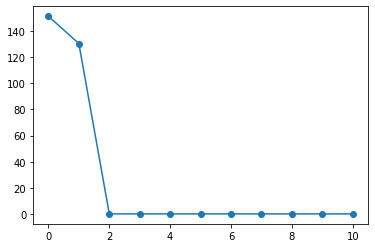

In [ ]:
m, n, k = 100, 40, 5
rand_seed = 10
np.random.seed(rand_seed)

def check_lorma_learn():
    from numpy.random import binomial, randn, uniform
    mockA, mockB = uniform(1, 2, (m, k)), uniform(-2, -1, (k, n))
    M = mockA @ mockB + 0.01 * np.random.randn(m, n)
    O = binomial(1, 0.5, size=M.shape)
    epochs = 100
    eta = 2.0 * np.ones(epochs)
    params = k, epochs, eta
    A, B, l = lorma_learn(M, O, params)
    plt.plot(l , '-o')
    return M, A, B

M, A, B = check_lorma_learn()

### Visualizing the data matrix and it low-rank approximation

For reference let us also visualize a random matrix from the same distribution used for initialization. 

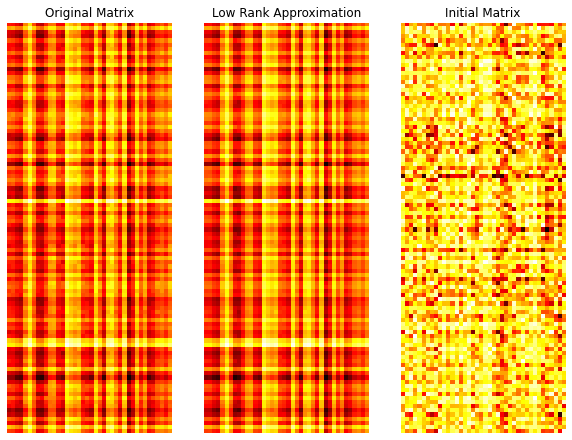

In [ ]:
def show_mat(X, str, ind):
    plt.subplot(1,3,ind)
    plt.imshow(X, cmap='hot')
    plt.axis('off')
    plt.title(str)

Ar, Br = lorma_init(m, n, k)
fig = plt.figure(figsize=(10,60))
show_mat(M, 'Original Matrix', 1)
show_mat(lorma(A, B), 'Low Rank Approximation', 2)
show_mat(lorma(Ar, Br), 'Initial Matrix', 3)

<hr style="border:3px solid blue"> </hr>


## Movie Recommendation

In movie recommendation, you are given data about users and their movie preferences, and you have to recommend movies that the users have not seen, and will like.
using dataset called [MovieLens](https://grouplens.org/datasets/movielens/).

In [ ]:
"""
In this code cell, we will first download the MovieLens data.
We will then convert the data into a matrix form instead of a list form.

The matrix will have people as rows and movies (or Movie IDs) as columns.

We will also download the movie names corresponding to the movie IDs.
"""

# Imports for loading and splitting data
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the MovieLens dataset
# Rows are users and columns are different movies

# Load the data from GitHub
movie_ratings_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/ratings.csv'
movielens_raw = pd.read_csv(movie_ratings_path)

# Process the data to get it in the right format
# The data consists of rows - (userID, movie_ID, rating, timestamp)
# We want to convert it to a matrix where the rows are users and the columns are movies
# We will fill missing values with -1, a value that is not present in the dataset
missing_value = -1
movielens_data = movielens_raw.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(missing_value).to_numpy()

# Create the observed matrix O. It should be boolean matrix with True for observed entries and false otherwise
movielens_observed = (movielens_data != -1) + 0

# We'll convert the boolean matrix to an integer matrix
movielens_observed = movielens_observed.astype(int)

# Let's create a copy of the data because we'll need it later
movielens_data_copy = movielens_data.copy()


# Load the movie names
# The data consists of rows which are movie IDs
movie_names_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/movies.csv'
movie_names = pd.read_csv(movie_names_path)

e :  0 1.3936
e :  10 0.989
e :  20 0.9083
e :  30 0.8727
e :  40 0.8519
e :  50 0.8378
e :  60 0.8273
e :  70 0.8188
e :  80 0.8117
e :  90 0.8054
e :  100 0.7996
e :  110 0.7942
e :  120 0.7888
e :  130 0.7833
e :  140 0.7777
e :  150 0.7718
e :  160 0.7654
e :  170 0.7584
e :  180 0.7508
e :  190 0.7424
e :  200 0.7331
e :  210 0.723
e :  220 0.7121
e :  230 0.7006
e :  240 0.6885
e :  250 0.6763
e :  260 0.664
e :  270 0.6519
e :  280 0.6401
e :  290 0.6286
e :  300 0.6175
e :  310 0.6068
e :  320 0.5964
e :  330 0.5863
e :  340 0.5764
e :  350 0.5667
e :  360 0.5571
e :  370 0.5477
e :  380 0.5384
e :  390 0.5292
e :  400 0.5201
e :  410 0.5111
e :  420 0.5022
e :  430 0.4934
e :  440 0.4847
e :  450 0.4761
e :  460 0.4676
e :  470 0.4592
e :  480 0.4509
e :  490 0.4427
e :  500 0.4346
e :  510 0.4267
e :  520 0.4189
e :  530 0.4112
e :  540 0.4036
e :  550 0.3962
e :  560 0.389
e :  570 0.3819
e :  580 0.3749
e :  590 0.3681
e :  600 0.3614
e :  610 0.3549
e :  620 0.3485
e :  63

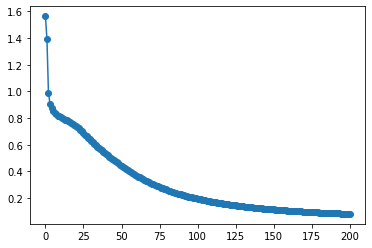

In [ ]:
"""
We'll run LORMA on the MovieLens data
"""

rand_seed = 10
np.random.seed(rand_seed)

# Normalize the MovieLens train data
movielens_normalized = normalize_matrix(movielens_data, movielens_observed)
# Define the parameters for LORMA
low_rank = 40
# For debugging run for 100 epochs then switch back to the parameters below
epochs = 2000
eta = 10.0 * np.ones(epochs)
params = low_rank, epochs, eta

# Run LORMA
A, B, losses = lorma_learn(movielens_normalized, movielens_observed, params)

# Plot the losses to make sure they are decreasing
_ = plt.plot(losses , '-o')

In [ ]:
"""
We'll pick three users and see what movies they liked before, and what movies your model predicted.
Hopefully there is some correlation!

In this cell we first print out some movies that they have liked
"""

# Pick three users to recommend movies to
users = [1,13, 111]

# Let's see their tastes. Print the top-p movies they have rated highly
p = 10
for user in users:
    print("\nUser {} liked the following:\n".format(user))
    
    # Sort the movies for this user in descending order based on the rating
    movie_order = np.argsort(-movielens_data[user])
    top_p = movie_order[:p]
    
    # Print the movies
    for movie in top_p:
        print("\t{:<50} rated {:.1f}  genres {:<30}".format(movie_names.iloc[movie]['title'], movielens_data_copy[user, movie], movie_names.iloc[movie]['genres']))


User 1 liked the following:

	The Final Girls (2015)                             rated 5.0  genres Comedy|Horror                 
	Conan the Barbarian (2011)                         rated 5.0  genres Action|Adventure|Fantasy      
	I'm Still Here (2010)                              rated 5.0  genres Comedy|Drama                  
	The Hungover Games (2014)                          rated 5.0  genres Comedy                        
	Ender's Game (2013)                                rated 5.0  genres Action|Adventure|Sci-Fi|IMAX  
	Zombie Strippers! (2008)                           rated 5.0  genres Comedy|Horror                 
	10,000 BC (2008)                                   rated 4.5  genres Adventure|Romance|Thriller    
	For Richer or Poorer (1997)                        rated 4.5  genres Comedy                        
	Piranha (Piranha 3D) (2010)                        rated 4.5  genres Action|Horror|Thriller        
	Sunshine Cleaning (2008)                           rated 4.5

In [ ]:
"""
User 1 seems to like Comedy and Horror
User 13 seems to like Drama and Romance
User 111 seems to like Sci-Fi and Adventure

Now let's make our predictions on the test data and see what movies we can recommend

"""

for user in users:
    print("\nRecommend the following movies to User {}\n".format(user))
    
    # Predict the rating for these movies by performing a matrix multiplication between the user and movie vectors
    predicted_ratings = A[user,:] @ B
    
    # If the movie review was observed in the matrix, set it to (-infinity) so that we don't predict it
    # We want to predict only from a set of movies which the user has not seen
    predicted_ratings[movielens_observed[user]] = -np.inf
    
    # Choose the top_p movies
    predicted_movie_order = np.argsort(-predicted_ratings)
    top_p = predicted_movie_order[:p]
    
    # Print the recommended movies
    for movie in top_p:
        print("\t{:<60} genres {:<30}".format(movie_names.iloc[movie]['title'][:60], movie_names.iloc[movie]['genres']))


Recommend the following movies to User 1

	Exorcist II: The Heretic (1977)                              genres Horror                        
	Apt Pupil (1998)                                             genres Drama|Thriller                
	Away from Her (2006)                                         genres Drama                         
	What's Up, Doc? (1972)                                       genres Comedy                        
	Goonies, The (1985)                                          genres Action|Adventure|Children|Comedy|Fantasy
	Prizzi's Honor (1985)                                        genres Comedy|Drama|Romance          
	Emma (2009)                                                  genres Comedy|Drama|Romance          
	Robin Hood: Men in Tights (1993)                             genres Comedy                        
	Jaws 2 (1978)                                                genres Horror|Thriller               
	I'm Still Here (2010)                         